# **Predicting the Loan Defaulters of NBFI Vehicle Loan Repayment**
_An analysis aimed to find the behavior of loan defaulters and predict them._

![img](https://i.imgur.com/sgPNdLg.jpg)



## **Introduction**
A loan is a concept of lending money to people and organization which has to be repayed back as debt along with interest. Loans are so popular because people can easily buy things like
- Vehicles
- Assets
- Commodities

and other things which they can't afford to buy. Thus by taking a loan they can fulfill their requirements and pay they debt of the loan amount in regular intervals.
Though the concept of loans may seem as a simple process, it is not that simple for the banks providing the loans to the customers. The customers have to be properly scrutinized, and selected to provide loans. Provding loans to people who are not qualified can cause a loss to the bank, and when this happens on a large scale will make the financial institution go bankrupt. A perfect example for this scenario is the **`2008 subprime crises`**.

**This notebook revolves around analysing the behaviour of the customers who borrowed loans and building a prediction framework to find the loan defaulters.**

##### The following steps will be followed in the notebook :
- Downloading the [NBFI Loan Dataset](https://www.kaggle.com/datasets/meastanmay/nbfi-vehicle-loan-repayment-dataset?select=Train_Dataset.csv) from Kaggle.
- Installing and Importing Essential Libraries for Analysis.
- Preprocessing and Data Cleaning.
- Exploratory Data Analysis (EDA).
- Machine Learning Model Building and Hyperparameter Tuning.
- Conclusion
- Summary
- References


## **Downloading the NBFI Loan Dataset from Kaggle**

In [340]:
!pip install opendatasets --quiet


[opendatsets](https://pypi.org/project/opendatasets/#:~:text=opendatasets%20is%20a%20Python%20library,using%20a%20simple%20Python%20command.) is a python library used for downloading datasets from kaggle and google drive effortlessly

In [341]:
import opendatasets as od

In [342]:
url="https://www.kaggle.com/datasets/meastanmay/nbfi-vehicle-loan-repayment-dataset?select=Train_Dataset.csv"
od.download(url)

Skipping, found downloaded files in "./nbfi-vehicle-loan-repayment-dataset" (use force=True to force download)


For the analysis we will be using the Train_Dataset.csv

In [343]:
file_path='./nbfi-vehicle-loan-repayment-dataset/Train_Dataset.csv'

## **Installing and Importing Essential Libraries for Analysis**


In [344]:
!pip install pandas numpy matplotlib plotly.express seaborn pyarrow wordcloud scikit-learn --quiet

In [345]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
from sklearn.tree import plot_tree, export_text

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


sns.set_style('white')
plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['figure.facecolor'] = '#00000000'
plt.rcParams['xtick.major.pad']='10'
plt.rcParams['ytick.major.pad']='10'
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


### **About the Data**

In [346]:
raw_df=pd.read_csv(file_path)


In [347]:
df=raw_df.copy()

Lets build a function `feature_desc` which prints the description of a feature.

In [348]:
def feature_desc(feature):
    schema=pd.read_csv("./nbfi-vehicle-loan-repayment-dataset/Data_Dictionary.csv")
    return feature +" : "+schema[schema['Variable']==feature]['Description'].item()


Lets go ahead and print the first 15 features's description.

In [349]:
for col in df.columns[:15]:
    print(feature_desc(col))

ID : Client Loan application ID
Client_Income : Client Income in $
Car_Owned : Any Car owned by client before applying for the loan for another car (0 means No and 1 means otherwise)
Bike_Owned : Any bike owned by client (0 means No and 1 means otherwise)
Active_Loan : Any other active loan at the time of aplication of loan (0 means No and 1 means otherwise)
House_Own : Any house owned by client (0 means No and 1 means otherwise)
Child_Count : Number of children the client has
Credit_Amount : Credit amount of the loan in $
Loan_Annuity : Loan annuity in $
Accompany_Client : Who accompanied the client when client applied for the loan
Client_Income_Type : Clients income type
Client_Education : Highest level of education ahieved by client
Client_Marital_Status : Marital status of client (D- Divorced, S- Single, M- Married, W- Widowed)
Client_Gender : Gender of the Client
Loan_Contract_Type : Loan Type (CL- Cash Loan, RL- Revolving Loan)


In [350]:
feature_desc("Age_Days")

'Age_Days : Age of the client at the time of application submission'

## **Preprocessing and Data Cleaning**

Lets filter the df by droping a few columns.

In [351]:
df.drop(['Client_Occupation','Social_Circle_Default','Credit_Bureau','Own_House_Age','Cleint_City_Rating'], axis=1, inplace=True)

### **Duplicates**

In [352]:
len(df[df.duplicated()])

0

The dataset has 0 duplicates.

### **Changing Datatypes**

In [353]:
non_numeric =['Car_Owned','Bike_Owned','Active_Loan','House_Own','Mobile_Tag','Homephone_Tag','Workphone_Working','Phone_Change','Default','Accompany_Client','Client_Income_Type','Client_Education','Client_Marital_Status','Client_Gender','Loan_Contract_Type','Client_Housing_Type','Client_Permanent_Match_Tag','Client_Contact_Work_Tag','Client_Family_Members']
to_numeric  =['Population_Region_Relative', 'Age_Days', 'Employed_Days', 'Registration_Days', 'ID_Days', 'Credit_Amount', 'Loan_Annuity', 'Client_Income','Score_Source_3']

Lets convert some of the numeric columns identified as object by pandas to numeric columns. And categorical columns identified as object to categorical columns.

In [354]:
for col in to_numeric:
    df[col]=pd.to_numeric(df[col], errors='coerce')

for col in non_numeric:
    df[col]=df[col].astype('category')

In [355]:
df.Default.value_counts()

Default
0    112011
1      9845
Name: count, dtype: int64

### **Missing Values**

In [356]:
pd.DataFrame(df.isnull().sum())

0
ID                              0
Client_Income                3622
Car_Owned                    3581
Bike_Owned                   3624
Active_Loan                  3635
House_Own                    3661
Child_Count                  3638
Credit_Amount                3637
Loan_Annuity                 4826
Accompany_Client             1746
Client_Income_Type           3701
Client_Education             3645
Client_Marital_Status        3473
Client_Gender                2413
Loan_Contract_Type           3651
Client_Housing_Type          3687
Population_Region_Relative   4868
Age_Days                     3617
Employed_Days                3666
Registration_Days            3631
ID_Days                      5985
Mobile_Tag                      0
Homephone_Tag                   0
Workphone_Working               0
Client_Family_Members        2410
Application_Process_Day      2428
Application_Process_Hour     3663
Client_Permanent_Match_Tag      0
Client_Contact_Work_Tag         0
Type_Organization            3609
Score_Source_1              68835
Score_Source_2               5686
Score_Source_3              26922
Phone_Change                 3664
Default                         0

Lets go ahead and check the description of Score_Source_1 and Score_Source_3, before dropping them, sicne they have a lot of missing data.

In [357]:
feature_desc("Score_Source_1")

'Score_Source_1 : Score sourced from other source. This is a normalzied socre'

In [358]:
feature_desc("Score_Source_3")

'Score_Source_3 : Score sourced from other source. This is a normalzied socre'

Both these are scores given to people based on the other features. Thus they will play an important role is classifying `defaulters`. So lets replace them with minimum of frequently occuring value for defaulters and non defaulters.

In [359]:
default_df=df[df.Default==1].copy()
default_df.loc[default_df['Score_Source_1'].isna(), 'Score_Source_1']=default_df['Score_Source_1'].mode().min()

not_default_df=df[df.Default==0].copy()
not_default_df.loc[not_default_df['Score_Source_1'].isna(), 'Score_Source_1']=not_default_df['Score_Source_1'].mode().min()

df=pd.concat([default_df,not_default_df])

In [360]:
default_df=df[df.Default==1].copy()
default_df.loc[default_df['Score_Source_3'].isna(), 'Score_Source_3']=default_df['Score_Source_3'].mode().min()

not_default_df=df[df.Default==0].copy()
not_default_df.loc[not_default_df['Score_Source_3'].isna(), 'Score_Source_3']=not_default_df['Score_Source_3'].mode().min()

df=pd.concat([default_df,not_default_df])

In [361]:
pd.DataFrame(df.isnull().sum())

0
ID                             0
Client_Income               3622
Car_Owned                   3581
Bike_Owned                  3624
Active_Loan                 3635
House_Own                   3661
Child_Count                 3638
Credit_Amount               3637
Loan_Annuity                4826
Accompany_Client            1746
Client_Income_Type          3701
Client_Education            3645
Client_Marital_Status       3473
Client_Gender               2413
Loan_Contract_Type          3651
Client_Housing_Type         3687
Population_Region_Relative  4868
Age_Days                    3617
Employed_Days               3666
Registration_Days           3631
ID_Days                     5985
Mobile_Tag                     0
Homephone_Tag                  0
Workphone_Working              0
Client_Family_Members       2410
Application_Process_Day     2428
Application_Process_Hour    3663
Client_Permanent_Match_Tag     0
Client_Contact_Work_Tag        0
Type_Organization           3609
Score_Source_1                 0
Score_Source_2              5686
Score_Source_3                 0
Phone_Change                3664
Default                        0

In [362]:
df.isnull().sum().sum()

95767

In [363]:
df=df.dropna()

In [364]:
df.isnull().sum().sum()

0

### **Outliers**

In [365]:
df.describe()

ID  Client_Income   Child_Count  Credit_Amount  Loan_Annuity   
count  5.480700e+04   5.480700e+04  54807.000000   54807.000000  54807.000000  \
mean   1.216097e+07   1.688656e+04      0.412995   60085.454669   2719.254239   
std    3.517674e+04   1.286801e+04      0.724439   40396.387135   1461.352804   
min    1.210000e+07   2.565000e+03      0.000000    4500.000000    217.350000   
25%    1.213045e+07   1.125000e+04      0.000000   27000.000000   1656.450000   
50%    1.216102e+07   1.440000e+04      0.000000   51741.900000   2493.900000   
75%    1.219141e+07   2.025000e+04      1.000000   80865.000000   3465.225000   
max    1.222186e+07   1.800009e+06     14.000000  405000.000000  22500.000000   

       Population_Region_Relative      Age_Days  Employed_Days   
count                54807.000000  54807.000000   54807.000000  \
mean                     0.020804  16047.056398   67478.163337   
std                      0.013877   4366.209483  139248.153389   
min                      0.000533   7676.000000       0.000000   
25%                      0.010006  12410.000000     927.000000   
50%                      0.018850  15778.000000    2201.000000   
75%                      0.028663  19677.000000    5687.500000   
max                      0.072508  25197.000000  365243.000000   

       Registration_Days       ID_Days  Application_Process_Day   
count       54807.000000  54807.000000             54807.000000  \
mean         4957.756418   2981.122411                 3.153630   
std          3513.450104   1510.723870                 1.757777   
min             0.000000      0.000000                 0.000000   
25%          1989.000000   1697.000000                 2.000000   
50%          4464.000000   3231.000000                 3.000000   
75%          7434.500000   4288.000000                 5.000000   
max         22701.000000   6263.000000                 6.000000   

       Application_Process_Hour  Score_Source_1  Score_Source_2   
count              54807.000000    54807.000000    54807.000000  \
mean                  12.066105        0.364595        0.516198   
std                    3.273498        0.186463        0.630820   
min                    0.000000        0.017177        0.000005   
25%                   10.000000        0.270675        0.387632   
50%                   12.000000        0.270675        0.563413   
75%                   14.000000        0.454022        0.662982   
max                   23.000000        0.945741      100.000000   

       Score_Source_3  
count    54807.000000  
mean         0.547817  
std          0.210173  
min          0.000527  
25%          0.404878  
50%          0.597192  
75%          0.746300  
max          0.896010

In [366]:
outlier_cols_numeric=['Client_Income','Child_Count', 'Credit_Amount', 'Loan_Annuity','Employed_Days','Registration_Days','ID_Days']

Lets delete all the outliers in the numeric data using `IQR method`.

In [367]:
for col in outlier_cols_numeric:
    q1=df[col].quantile(0.25)
    q3=df[col].quantile(0.75)
    iqr=(q3-q1)
    df=df[~(  (df[col]<(q1- 1.5*iqr)) | (df[col]>(q3+1.5*iqr)) )]

In [368]:
df['Child_Count']=df['Child_Count'].astype('category')

## **Explorartory Data Analysis**

#### In this section lets analyse the dataset by asking and answering questions. 

#### 1. How is the liabilities distributed for all applicants of the loan ?

In [369]:
car_owned=df['Car_Owned'].map({1:"Yes", 0:"No"})
bike_owned=df['Bike_Owned'].map({1:"Yes", 0:"No"})
active_loan=df['Active_Loan'].map({1:"Yes", 0:"No"})
house_owned=df['House_Own'].map({1:"Yes", 0:"No"})

fig = sp.make_subplots(rows=2, cols=2, subplot_titles=('Car Owned', 'Bike Owned', 'Active Loans', 'House Owned'))
fig.add_trace(go.Histogram(x=car_owned,opacity=0.7, histnorm="percent", marker_color='darkseagreen'), row=1, col=1)
fig.add_trace(go.Histogram(x=bike_owned,opacity=0.7, histnorm="percent", marker_color='crimson'), row=1, col=2)
fig.add_trace(go.Histogram(x=active_loan,opacity=0.7, histnorm="percent",marker_color='deepskyblue'), row=2, col=1)
fig.add_trace(go.Histogram(x=house_owned, opacity=0.7, histnorm="percent"), row=2, col=2)

fig.update_layout(title_text='Relative Distributions of Liabilities')
fig.show()


#### Insights from the Histograms:

- The liabilities gathered from the dataset are Car Owned, Bike Owned, Active Loans and House Owned.
- Out of 100 % of the applicants 63% do not own a car.
- Out of 100 % of the applicants 66% do not own a bike.
- Out of 100 % of the applicants 50% do not have a active loan.
- Out of 100 % of the applicants 67% own a house.
- Overall most of the applicants have less liability.

#### 2. What is the distribution of no of kids of all the applicants ?

In [370]:
data=df.Child_Count.value_counts().reset_index()

data['Child_Count']=data['Child_Count'].map({0:"No Children", 1:" One Child", 2:"Two Kids"})
fig = px.pie(data, values='count', names='Child_Count',color_discrete_sequence=['darkseagreen'])
fig.update_layout(title="Distribution of number of kids for the Applicants")
fig.show()


#### Insights from the Pie Chart
- Out of the total applicants 65.5 of them have no children.
- 24 % of the applicants have one kid.
- And 10.5% of them have two kids.

Lets go ahead and create a function `rel_default_cal` for calculating the relative frequency for each category in the categorical columns with respect to the loan defaulted column.

In [371]:
def rel_deafult_cal(col,df):
    res={}
    categories=df[col].unique().tolist()
    for category in categories:

        val=(len(df[(df[col]==category)&(df.Default==1)])/ len(df[df[col]==category]))*100
        res[category]=val
    return res


The above function iterates through all the category in a categorical column and filters the rows that have loan defaulters and then calculates the relative frequency with respect to the entire column.

In [372]:
result=rel_deafult_cal("Client_Income_Type", df)
result

{'Service': 9.682625067240453,
 'Commercial': 8.143292401440311,
 'Govt Job': 6.451612903225806,
 'Student': 0.0}

In the above example we find the relative frequency of `Client_Income_Type` who have defaulted. Comparing the relative frequencies of all the categories in a categorical column gives us the actual picture of the distribution.

### 3. What is the relative frequency of defaulters from different job sectors ?

In [373]:
fig=px.bar(y=[result['Service'], result["Commercial"], result["Govt Job"]],x=['Service Jobs', 'Commercial Jobs', 'Govt Jobs'], title="Relative Frequency of Defaulters from Different Jobs",opacity=0.7, color_discrete_sequence=["darkseagreen"] )
fig.show()

#### Insights from the Histogram
- Service job sector has the highest with 9.6% of defaulters from the servide sector.
- Followed by the Commenrcial job sector with 8%.
- And Government job with 6%.

### 4. What is frequency of defaulters of among men and women ?

In [374]:
result=rel_deafult_cal("Client_Gender",df)
fig=px.bar(y=[result['Female'], result['Male']],x=['Women Defaulted', 'Men Defaulted'], title="Relative Frequency of Women vs. Men Defaulted", color=['pink', 'blue'], opacity=0.7, color_discrete_sequence=["darkseagreen", 'crimson'])
fig.update_xaxes(title="Percentage (%)")
fig.update_yaxes(title="Type")
fig.show()

#### Insights from the Histogram
- The number of defaulters among women is 10%.
- The number of defaulters among men is 7%

### 5. Plot a frequency distribution defaulters who have taken Cash Loans and Revolving Loans. 

In [375]:
result=rel_deafult_cal('Loan_Contract_Type', df)
px.bar(y=[result['CL'], result['RL']], x=['Cash Loan', 'Revolving Loan'], title="Relative Frequency of Cash Loan Vs. Revoling Loan Defaulted",color_discrete_sequence=["darkseagreen"], opacity=0.7)

#### Insights from the histogram
- Customers that have taken cash loans have defaulted more with around 9.31%.
- And revoling loan customers have defaulted with 5.99 %.

### 6. What is the relative frequency of defaulters based on client housing type ?

In [376]:
result=rel_deafult_cal('Client_Housing_Type', df)
px.bar(y=[result['Rental'],result['Shared'],result['Family'], result['Municipal'],result['Home'],result['Office']], x=['Rental', 'Shared','Family','Municipal', 'Home','Office' ], title="Relative Frequency of Cash Loan Vs. Revoling Loan Defaulted",color_discrete_sequence=["darkseagreen"], opacity=0.7)


#### Insights from the histogram
- Rental and Shared housing type has most defaulters with 13 %.
- Followed by family with 12%.
- Municipal and Home have around 8%.
- Office being 7%.

### 7. How is distribution of client income different credit amount ?

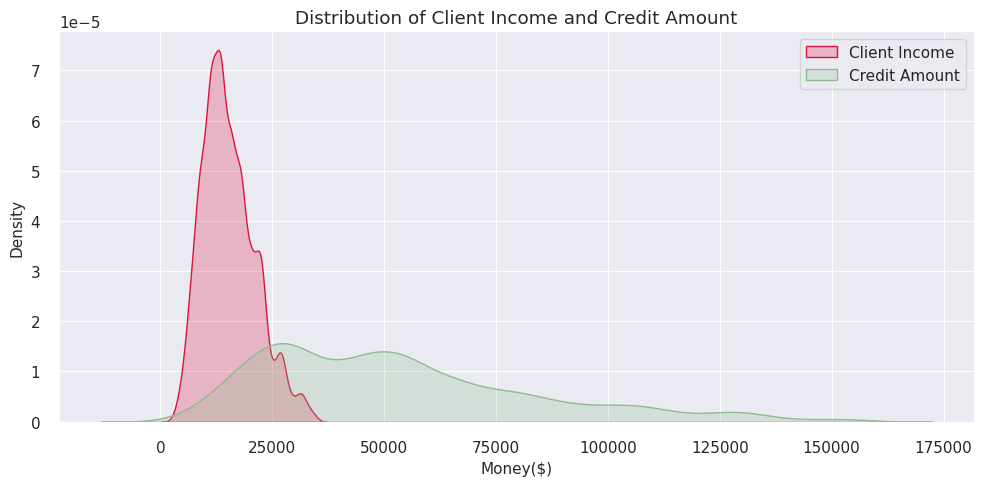

In [377]:

fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(data=df[df.Default==1]['Client_Income'],
            color='crimson', label='Client Income', ax=ax, fill=True)
sns.kdeplot(data=df[df.Default==1]['Credit_Amount'],
            color='darkseagreen', label='Credit Amount', ax=ax, fill=True)

ax.legend()
ax.set_title("Distribution of Client Income and Credit Amount")
ax.set_xlabel('Money($)')
plt.tight_layout()
plt.show()

In [378]:
fig = make_subplots(rows=2, cols=1, subplot_titles=("Client Income","Credit Amount"))
fig.add_box(x=df[df.Default==1]['Client_Income'], row=1, col=1, marker_color='crimson')
fig.add_box(x=df[df.Default==1]['Credit_Amount'], row=2, col=1, marker_color='darkseagreen')
fig.update_layout(title="Box plot of Client Income and Credit Amount")
fig.show()

#### Insights from KDE and Box Plot
- The Kde plot of `Client Income` is spread from 0 to 33K
- Whereas the spread of `Credit_Amount` taken by the customer lies from 0 to 1 L.
- Thus the `Credit_Amount` taken by the customers is almost double to their income. 

### 8. Plot the distribution of ID, Registration and Employed Days of people who have defaulted.

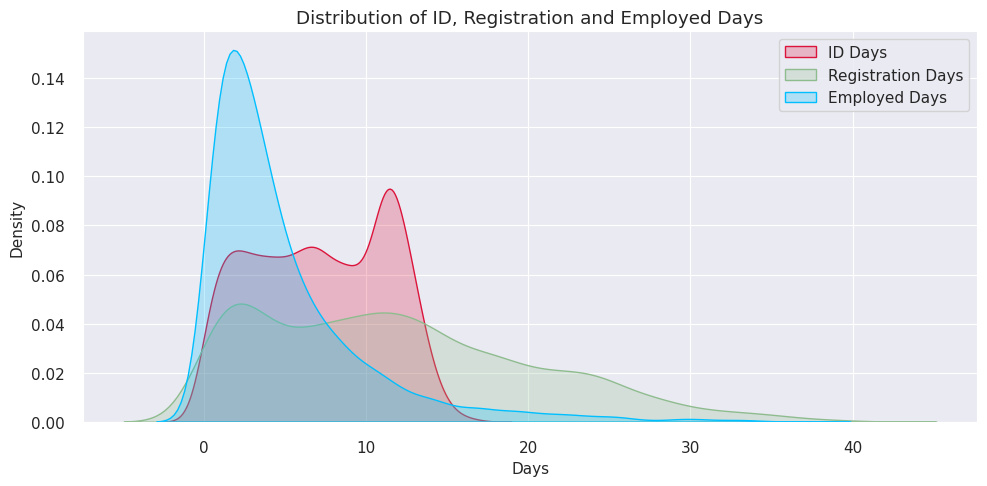

In [379]:

fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(data=df[df.Default==1]['ID_Days']/365,
            color='crimson', label='ID Days', ax=ax, fill=True)
sns.kdeplot(data=df[df.Default==1]['Registration_Days']/365,
            color='darkseagreen', label='Registration Days', ax=ax, fill=True)
sns.kdeplot(data=df[df.Default==1]['Employed_Days']/365,
            color='deepskyblue', label='Employed Days', ax=ax, fill=True)
ax.legend()
ax.set_xlabel('Days')
ax.set_title("Distribution of ID, Registration and Employed Days")
plt.tight_layout()
plt.show()

In [380]:
fig = make_subplots(rows=3, cols=1, subplot_titles=("ID Days","Registration Days", "Employed Days"))
fig.add_box(x=df[df.Default==1]['ID_Days']/365, row=1, col=1, marker_color='crimson')
fig.add_box(x=df[df.Default==1]['Registration_Days']/365, row=2, col=1, marker_color='darkseagreen')
fig.add_box(x=df[df.Default==1]['Employed_Days']/365, row=3, col=1, marker_color='skyblue')

fig.update_layout(title="Box plot of ID, Registration and Employed Days")
fig.show()

#### Insights from the KDE Plot and Box plot.
- `ID_Days` ranges from 0 to 16 days with median 7 days.
- `Registration_Days` ranges from 0 to 40 days with median 10 days.
- `ID_Days` ranges from 0 to 16 days with median 3 days.

### 9. Plot the distribution of contact information of customers.

In [381]:
homephone=df.Homephone_Tag.map({1:"Provided",0:"Not Provided"})
mobilephone=df.Mobile_Tag.map({1:"Provided",0:"Not Provided"})
workphone=df.Workphone_Working.map({1:"Provided",0:"Not Provided"})

fig = sp.make_subplots(rows=2, cols=2, subplot_titles=('Home Phone', 'Mobile Phone', 'Work Phone'))

fig.add_trace(go.Histogram(x=homephone,opacity=0.7, histnorm="percent",marker_color='darkseagreen'), row=1, col=1)
fig.add_trace(go.Histogram(x=mobilephone,opacity=0.7, histnorm="percent",marker_color='crimson'), row=1, col=2)
fig.add_trace(go.Histogram(x=workphone,opacity=0.7, histnorm="percent",marker_color='deepskyblue'), row=2, col=1)

fig.update_layout(title_text='Distribution of Contact Information')
fig.show()


#### Insights from the above histogram
- 75% of customers have not provided Home Phone number.
- 100% of cutomers have provided Mobile phone number.
- 72% of customers have given Work phone number.

# **Machine Learning Model Building and Hyperparameter Tuning**

### **Data Preparation for Machine Learning**

#### **Encoding**

Converting categorical columns into one hot and label encoded columns.

In [382]:
label_encoder = LabelEncoder()
non_numeric=df.select_dtypes(exclude=['number']).columns.tolist()

for col in non_numeric:
    df[col]=label_encoder.fit_transform(df[col])



#### **Correlation Matrix**
Lets find the relationship of different features with each other, and remove highly correlated columns which might affect the classification.

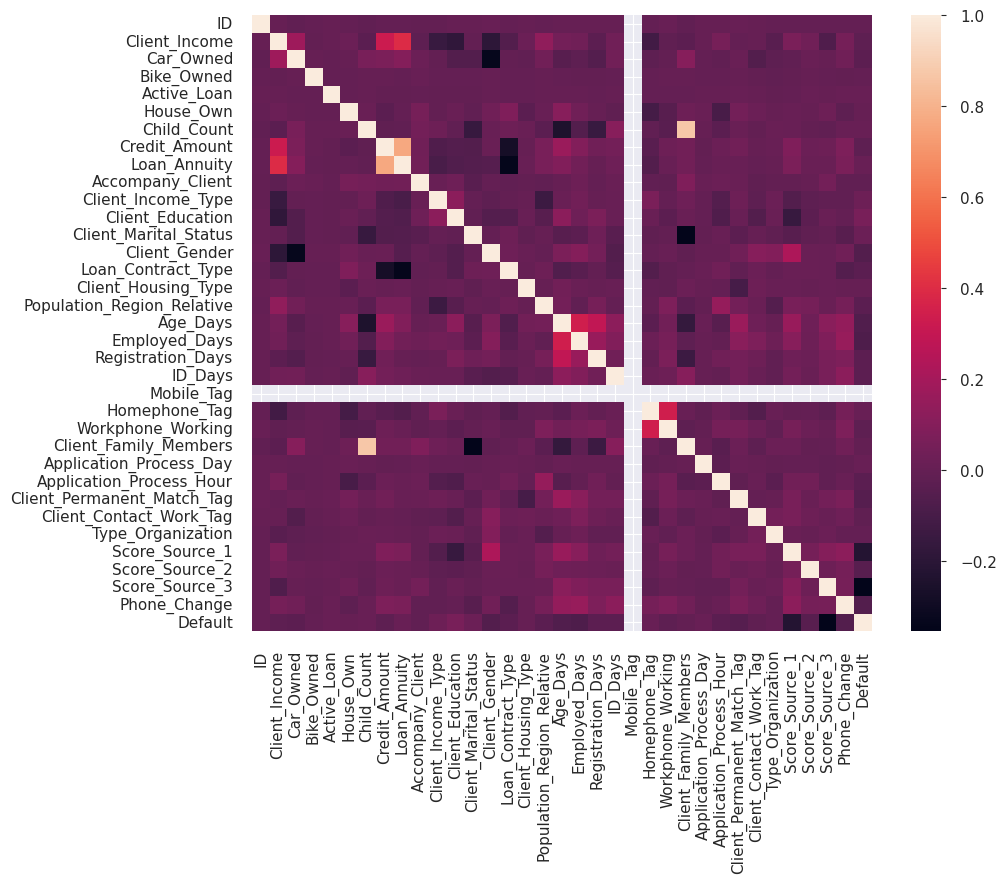

In [383]:
sns.heatmap(df.corr());

Dropping highly correlated columns.

In [384]:
to_drop=['Client_Family_Members','Credit_Amount','Car_Owned','Employed_Days']
df.drop(to_drop, axis=1, inplace=True)

Setting the `target column` and `input columns` for building the machine learning model.

In [385]:
target_col='Default'
input_cols=df.columns.tolist()
input_cols.remove('Default')

Spliting the dataset for  training and validating the model.

In [386]:
train_df,validation_df = train_test_split(df,test_size=0.1,random_state=42)
val_inputs = validation_df[input_cols]
val_target = validation_df[target_col]
train_inputs = train_df[input_cols]
train_target = train_df[target_col]

Lets create a function to predict and and show the accuracy, recall score and confusion matrix for a particular model.

In [387]:
def predict_and_plot(classifier,inputs,target):
    preds=classifier.predict(inputs)
    print(f"The Accuracy score of the model is {accuracy_score(target, preds):.2f}")
    print(f"The Recall score of the model is {recall_score(target, preds):.2f}")
    cm=confusion_matrix(target,preds)
    print(cm)
    return (accuracy_score(target, preds),recall_score(target, preds))


### **Evaluation Criteria**

The chosen evaluation metric is `Recall Score` so that we dont miss out on finding the defaulters.

### **Dummy Model**

In [388]:
val_target.value_counts()/len(val_target)

Default
0    0.901195
1    0.098805
Name: count, dtype: float64

From the above results its visible that the dummy model predicts 90% of the time that a person is non defaulted. So we have to make sure that our model does better than the above result.

In [389]:
conclude_dict={
    'model':[],
    'accuracy_score':[],
    'recall_score':[]
}

## **1. Logistic Regression**

In [390]:
log_model = LogisticRegression()
log_model.fit(train_inputs,train_target)
acc,rec=predict_and_plot(log_model,train_inputs, train_target)


The Accuracy score of the model is 0.91
The Recall score of the model is 0.00
[[32940     0]
 [ 3219     0]]


The accuracy of the model is 91% and the recall score is 0, this indicates that our model is no better than the dummy model ! Lets try some **hyperparameter tuning** to improve our model.

#### **Hyperparameter tuning for Logistic Regression**


##### Finding the best solver.

In [391]:
algos=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
dict_df={
    "algo":[],
    "accuracy_score":[],
    "recall_score":[]
}

for algo in algos:
    dict_df['algo'].append(algo)
    log_model = LogisticRegression(solver=algo)
    log_model.fit(train_inputs,train_target)
    train_preds=log_model.predict(train_inputs)
    dict_df['accuracy_score'].append(accuracy_score(train_target, train_preds))
    dict_df['recall_score'].append(recall_score(train_target, train_preds))



dict_df=pd.DataFrame(dict_df)
dict_df.sort_values('accuracy_score', ascending=False)

    


algo  accuracy_score  recall_score
0  newton-cg        0.922979      0.150668
1      lbfgs        0.910977      0.000000
2  liblinear        0.910977      0.000000
3        sag        0.910977      0.000000
4       saga        0.910977      0.000000

`newton-cg` solver tops the list with 92% accuracy score and recall of 0.15.

In [392]:
log_model = LogisticRegression(solver='newton-cg')
log_model.fit(train_inputs,train_target)
print("On Training set")
predict_and_plot(log_model,train_inputs, train_target)
print()
print("On Validation set")
acc,rec=predict_and_plot(log_model,val_inputs, val_target)




On Training set
The Accuracy score of the model is 0.92
The Recall score of the model is 0.15
[[32889    51]
 [ 2734   485]]

On Validation set
The Accuracy score of the model is 0.91
The Recall score of the model is 0.14
[[3615    6]
 [ 343   54]]


Since this accuracy score is quite less and its similar to the dummy model lets go ahead and try different machine learning model.

In [393]:
conclude_dict['model'].append('Logistic Regression')
conclude_dict['accuracy_score'].append(acc)
conclude_dict['recall_score'].append(rec)

## **2. Decision Trees**

In [394]:
classifier=DecisionTreeClassifier(random_state=42)
classifier.fit(train_inputs,train_target)
acc, rec=predict_and_plot(classifier,train_inputs, train_target)

The Accuracy score of the model is 1.00
The Recall score of the model is 1.00
[[32940     0]
 [    0  3219]]


The above decision tree model is 100% accurate in the training dataset, which means it has `overfitted` !

Lets go ahead and try it with the validation dataset.

In [395]:
acc, rec=predict_and_plot(classifier,val_inputs, val_target)

The Accuracy score of the model is 0.94
The Recall score of the model is 0.72
[[3507  114]
 [ 110  287]]


From the above model we see that the accuracy and recall is higher than our logistic regression model.

#### **Hyperparameter tuning for Decision Tree**


#### Max Depth

In [396]:
classifier.tree_.max_depth

40

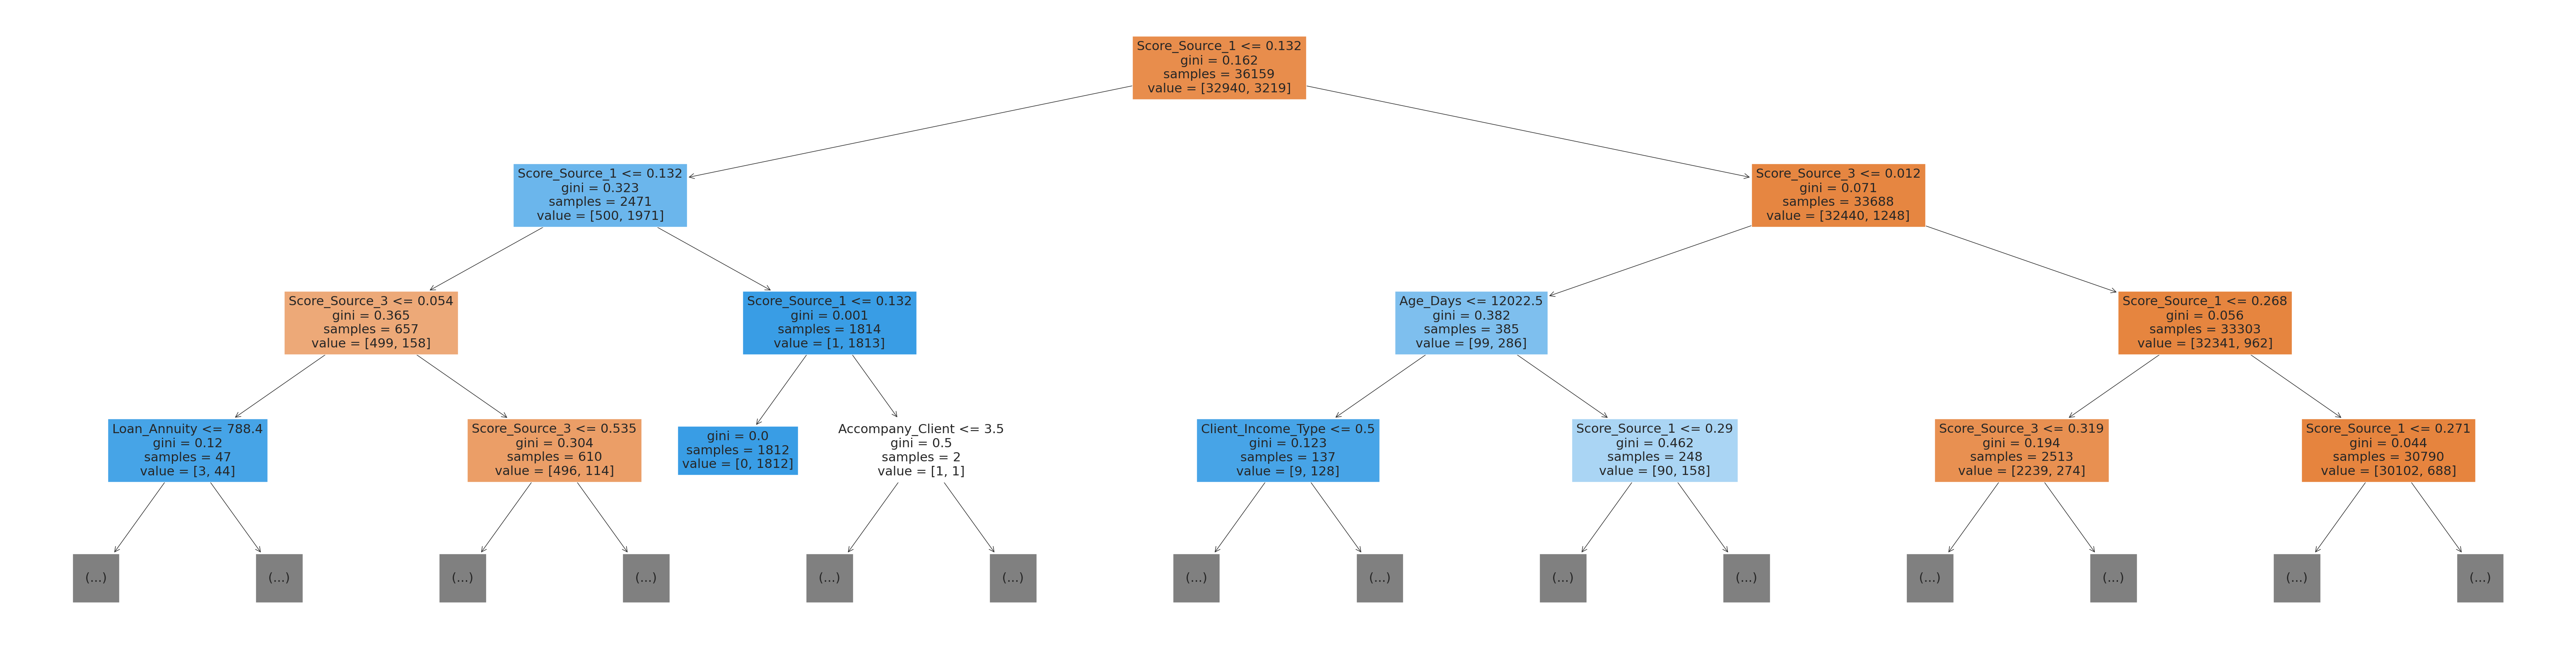

In [397]:
plt.figure(figsize=(80,20))
plot_tree(classifier, feature_names=train_inputs.columns, max_depth=3, filled=True);

In [398]:
dt_mx={"max_depth":[],"train_accuracy":[],"val_accuracy":[], "train_recall":[], "val_recall":[]}

for i in range(1, 30):
    dt_mx['max_depth'].append(i)
    classifier=DecisionTreeClassifier(random_state=42, max_depth=i)
    classifier.fit(train_inputs,train_target)
    train_preds=classifier.predict(train_inputs)
    val_preds=classifier.predict(val_inputs)
    dt_mx['train_accuracy'].append(accuracy_score(train_target, train_preds))
    dt_mx['val_accuracy'].append(accuracy_score(val_target, val_preds))
    dt_mx['train_recall'].append(recall_score(train_target, train_preds))
    dt_mx['val_recall'].append(recall_score(val_target, val_preds)) 
df_mx=pd.DataFrame(dt_mx)   

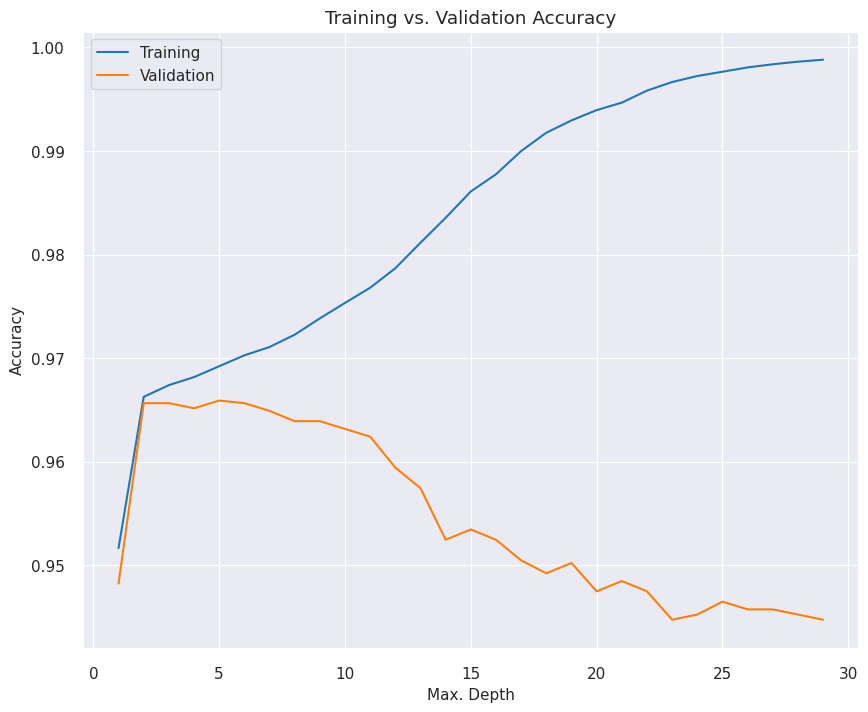

In [399]:
plt.plot(df_mx['max_depth'], df_mx['train_accuracy'])
plt.plot(df_mx['max_depth'], df_mx['val_accuracy'])
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Max. Depth')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation']);

From the above visualization its visible that after the depth of 3 the accuracy of the model in predicting the validation set is decreasing. This indicates the fact that the model starts to overfit after a depth of 3. Lets check the results by training the model with a depth of 3.

In [400]:
classifier=DecisionTreeClassifier(random_state=42, max_depth=3)
classifier.fit(train_inputs,train_target)
acc, rec=predict_and_plot(classifier,train_inputs,train_target)

The Accuracy score of the model is 0.97
The Recall score of the model is 0.67
[[32838   102]
 [ 1077  2142]]


In [401]:
acc, rec=predict_and_plot(classifier,val_inputs,val_target)

The Accuracy score of the model is 0.97
The Recall score of the model is 0.68
[[3609   12]
 [ 126  271]]


From the above results its visible that there is a increase in accuracy and decrease in recall when compared to the model before tuning the max_depth. But since the model is now not overfitting we see a that recall score is more in validation data when compared to training data, this is a good sign that our model has generalised well.

Lets try using ensembling methods to train out model.

In [402]:
conclude_dict['model'].append('Decision Tree')
conclude_dict['accuracy_score'].append(acc)
conclude_dict['recall_score'].append(rec)

## **3. Random Forest**

In [403]:
model=RandomForestClassifier(random_state=42)
model.fit(train_inputs, train_target)
print("On Training Data")
predict_and_plot(model,train_inputs, train_target)
print()
print("On Validation Data")
acc, rec=predict_and_plot(model,val_inputs, val_target)

On Training Data
The Accuracy score of the model is 1.00
The Recall score of the model is 1.00
[[32940     0]
 [    0  3219]]

On Validation Data
The Accuracy score of the model is 0.97
The Recall score of the model is 0.71
[[3612    9]
 [ 116  281]]


#### **Hyperparameter tuning for Random Forest using Grid Search CV**


Tuning n_estimators, max_depth and max_features of random forest.

In [404]:
from sklearn.model_selection import GridSearchCV
forest_params = [{'n_estimators': [1,2,3,4,5], 'max_depth':[1,2,3,4,5],'max_features':[1,2,3,4,5]}]
clf = GridSearchCV(model, forest_params, cv = 10, scoring='recall')
clf.fit(train_inputs, train_target)
print(clf.best_params_)
print(clf.best_score_)


{'max_depth': 4, 'max_features': 5, 'n_estimators': 3}
0.6579594048102784


In [405]:
model=RandomForestClassifier(random_state=42,max_depth=4, n_estimators=3, max_features=5)
model.fit(train_inputs, train_target)
print("On Training Data")
predict_and_plot(model,train_inputs, train_target)
print()
print("On Validation Data")
acc, rec=predict_and_plot(model,val_inputs, val_target)

On Training Data
The Accuracy score of the model is 0.96
The Recall score of the model is 0.69
[[32367   573]
 [ 1010  2209]]

On Validation Data
The Accuracy score of the model is 0.95
The Recall score of the model is 0.71
[[3547   74]
 [ 115  282]]


After tuning the `Random Forest` model with the parameters `max_depth, n_estimators, max_features` we get the same 71% recall before tuning, but the overfitting of the model has been reduced with a reduction in the accuracy. Moreover after tuning the recall in validation data is more when compared to the recall in the training data which indicates that the model has generalised well.

In [406]:
conclude_dict['model'].append('Random Forest')
conclude_dict['accuracy_score'].append(acc)
conclude_dict['recall_score'].append(rec)

# **Conclusion**

In [407]:
pd.DataFrame(conclude_dict).sort_values('recall_score', ascending=False)

model  accuracy_score  recall_score
2        Random Forest        0.952962      0.710327
1        Decision Tree        0.965655      0.682620
0  Logistic Regression        0.913141      0.136020

After building and tuning various models we come to a conclusion that Random Forest model has the highest recall score of 71% when compared to other models. We see that in `Logistic Regression` the accuracy is no better than the dummy model which had accuracy of 90% and the recall score is 13% which is very less. In decision tree we had a drastic improvement in recall score which was around 68% after tuning the hyperparameters to avoid overfitting. Moving ahead we trained a more stable ensemble model `Random Forest` which has accuracy of `95%` which 1% less than Decision Trees but has a higher recall score.

# **Summary**

- Downloaded to NBFI loan dataset from Kaggle.
    - Used the opendatasets library to download the dataset from kaggle.
- Installled and imported the necessary libraries for analysing and model building.
    - Installed necessary libraries such as pandas, numpy, matplotlib, scikitlearn etc.
    - Also imported the same.
- Preprocessing and Data Cleaning
    - Removed Duplicates.
    - Changed Datatypes of few columns.
    - Replacing and removing  missing values.
    - Removing outliers using IQR method.
    
- Performed Exploratory Data Analysis.
    - Found intersting insights about the data.
    - Found relationships between various features.
    - Found relationship between other features with the target feature.
    - Understood the distribution of various columns.
    - Used various various charts to visualise to data, used charts are as follows,
        - KDE Plot
        - Box Plot
        - Pie Chart
        - Histogram
        - Bar chart
- Prepared the data for model building.
    - Label Encoded the data
    - Ploted to corelation matrix and removed highly corelated features.
    - Spliting the data into training and validation datasets.

- Model Building.
    - Defined a Evaluation Criteria
    - Created a dummy model
    - Tranined and tuned various machine learning models

# **References**

- [Jovian Youtube Channel](https://www.youtube.com/@jovianhq)
- [Scikit Learn Documentation](https://scikit-learn.org/stable/)
- [Dealing with imbalanced dataset](https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets)
- [Plotly Documentation](https://plotly.com/python/)
- [Geeks for Geeks for troubleshooting](https://www.geeksforgeeks.org/)